# Basic preprocessing and analysis of the zebrafish data

Notebook preprocesses the zebrafish Smart-seq3 dataset.

## Library imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplscience

import scanpy as sc
import scvelo as scv
from velovi import preprocess_data

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.preprocessing import filter_genes, set_prior_grn

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packag

## General settings

In [2]:
sc.settings.verbosity = 2
scv.settings.verbosity = 3

In [3]:
plt.rcParams["svg.fonttype"] = "none"

## Constants

In [4]:
DATASET = "zebrafish"

In [5]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)

In [6]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

## Data loading

In [7]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "raw" / "adata_zebrafish_preprocessed.h5ad")
tfs = pd.read_csv(DATA_DIR / DATASET / "raw" / "zebrafish_tfs.csv", index_col=0).iloc[:, 0].tolist()
prior_net = pd.read_csv(DATA_DIR / DATASET / "raw" / "prior_GRN.csv", index_col=0)

In [8]:
## Only keep necessary TF list
keep_list = pd.read_csv(DATA_DIR / DATASET / "raw" / "keep_tf.csv", sep=";").iloc[:, 0].tolist()

In [9]:
sc.pp.neighbors(adata, n_neighbors=30)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:06)


In [10]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
adata

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


AnnData object with n_obs × n_vars = 697 × 8012
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'cell_type', 'stage'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'is_tf'
    uns: 'cell_type_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

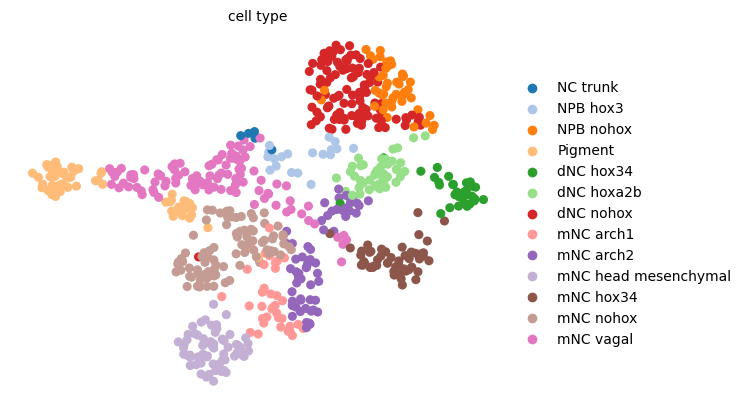

In [11]:
scv.pl.umap(adata, color="cell_type", palette=sc.pl.palettes.vega_20, legend_loc="right")

## Visualize results

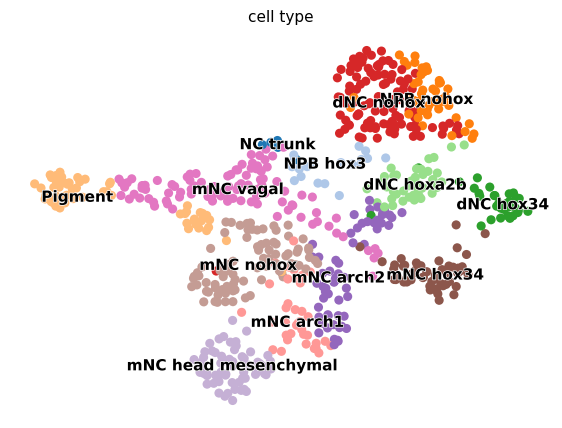

In [12]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(7, 5))
    scv.pl.umap(adata, color="cell_type", ax=ax, palette=sc.pl.palettes.vega_20)

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "INTRO_figure_all_ct.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show

## Visualize known terminal states

In [13]:
adata.obs["cell_type2"] = adata.obs["cell_type"].copy()
adata.obs["cell_type2"][
    ~adata.obs["cell_type2"].isin(["NPB_nohox", "mNC_hox34", "Pigment", "mNC_head_mesenchymal", "mNC_arch2"])
] = np.nan

In [14]:
adata.obs["cell_type2"] = adata.obs["cell_type2"].cat.remove_unused_categories()

In [15]:
palette = dict(zip(adata.obs["cell_type"].cat.categories, adata.uns["cell_type_colors"]))
subset_palette = {
    name: color for name, color in palette.items() if name in adata.obs["cell_type2"].cat.categories.tolist()
}

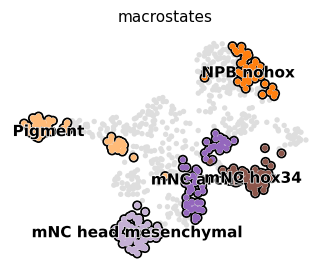

In [16]:
which = "macrostates"
adata.obs[which] = adata.obs["cell_type2"].copy()

state_names = adata.obs[which].cat.categories.tolist()
adata.obs[which] = adata.obs[which].astype(str).astype("category").cat.reorder_categories(["nan"] + state_names)

if which == "macrostates":
    adata.uns[f"{which}_colors"] = ["#dedede"] + list(subset_palette.values())
else:
    adata.uns[f"{which}_colors"] = ["#dedede"] + list(subset_palette.values())
state_names = adata.obs[which].cat.categories.tolist()[1:]


with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 3))
    scv.pl.scatter(
        adata,
        basis="umap",
        c=which,
        add_outline=state_names,
        ax=ax,
        size=60,
    )

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "INTRO_figure.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()

## Preprocessing

In [17]:
adata = set_prior_grn(adata, prior_net)

In [18]:
velocity_genes = preprocess_data(adata.copy()).var_names.tolist()

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [19]:
adata.var["TF"] = np.isin(adata.var_names, tfs)

Select genes that are either part of the transcription factor (TF) list or `velocity_genes`

In [20]:
## velocity_r2 positive genes
var_mask = np.union1d(list(set(keep_list).intersection(adata.var_names)), velocity_genes)

## Filtering genes, only keep velocity_r2 positive genes and TFs
adata = adata[:, var_mask].copy()

In [21]:
adata = filter_genes(adata)
adata = preprocess_data(adata, filter_on_r2=False)

Number of genes: 1013
Number of genes: 989
Number of genes: 988


In [22]:
# focus on velocity genes to ensure calculation stability
adata.var["velocity_genes"] = adata.var_names.isin(velocity_genes)

## Save dataset

In [23]:
if SAVE_DATA:
    adata.write_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")